In [66]:
import pandas as pd
import numpy as np
import pylab as plt
import geopandas as gpd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/nkwjones/anaconda3/envs/arcgis2/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
### Calculate AAL for hospitals in the 100-yr flood zone
* create a temporary column 'area2' based on scaling up the existing area data (this needs replacing with the real meters squared)
* set damage parameters including the depth-damage functions and maximum damage per m2 (building structure and content)
* 

In [307]:
hospitals = gpd.read_file('/Users/nkwjones/Desktop/temp/hosp2.shp')

In [308]:
cols=['Ile_a_Vach', 'Haiti_Nort', 'Haiti_No_1', 'Haiti_No_2', 'Haiti_Sout',
       'Haiti_Lowe', 'Haiti_Uppe', 'Haiti_So_1', 'Haiti_So_2']
hospitals['100yr'] = hospitals[cols].max(axis=1)
hospitals.drop(cols,inplace=True,axis=1)
hospitals['area2'] = hospitals['area']*10000000000
hospitals.head()

,area,id,lat,lon,name,elevation,ORIG_FID,geometry,100yr,area2
0,1.193119e-07,48564191,19.946933,-72.822550,CENTRE DE SANTE SOLEIL,10.640075,-1,POINT (-72.82254959999995 19.94693300000006),0.196896,1193.11885
1,3.157719e-07,130506153,19.944752,-72.775430,Health care,20.813026,-1,POINT (-72.77543039999995 19.94475180000006),0.757989,3157.71940
2,1.711719e-06,48557757,19.935781,-72.833091,Hopital Immaculee Conception (HIC),28.137547,-1,POINT (-72.83309149999997 19.93578070000007),0.000000,17117.18735
3,2.343094e-07,189705841,19.934259,-72.730288,Hopital autrichien de Saint-Louis du nord,11.666325,-1,POINT (-72.73028839999995 19.93425870000004),0.787395,2343.09390
4,1.382197e-08,221673492,19.846544,-72.522796,HOPE(CORPUS CHRISTI),14.747678,-1,POINT (-72.52279579999998 19.84654400000005),0.658403,138.21970


In [248]:
ADM = gpd.read_file('/Users/nkwjones/Desktop/CUSP/Monitoring Cities/haiti/Haiti_ADM_Polygons')

In [250]:
# Set damage variables

max_damage_content = 138 # euros per square meter
max_damage_structure = 92

depths = [0.0,0.5,1.0,1.5,2.0,3.0,4.0,5.0,6.0] # meters flood depth
depths = [str(x) for x in depths]

damage_func_structure = pd.DataFrame({"Health":[0.00,0.00, 0.67, 0.89, 0.95, 1.00, 1.00, 1.00, 1.00]})
damage_func_structure.index = depths
damage_func_content = pd.DataFrame({"Health":[0.00,0.00, 0.67, 0.89, 0.95, 1.00, 1.00, 1.00, 1.00]})
damage_func_content.index = depths
damage_func_content

,Health
0.0,0.00
0.5,0.00
1.0,0.67
1.5,0.89
2.0,0.95
3.0,1.00
4.0,1.00
5.0,1.00
6.0,1.00


In [309]:
def get_damage_factor(depth):
    
    ''' for a given depth in meters, fetch the corresponding
    damage factor from the damage_function dataframe'''
    
    new_depths = [0.0,0.5,1.0,1.5,2.0,3.0,4.0,5.0,6.0]
    if depth >= 6.0:
        return(damage_func_content.loc['6.0'][0])
    for i in new_depths:
        if depth <= i:
            return(damage_func_content.loc[str(i)][0])

In [310]:
def calc_AAL_structure_100(area, depth,return_period=100):
    
    '''AAL equals area * probability of event * max damage per sq m * damage factor'''
    
    damage_factor = get_damage_factor(depth)
    prob = 1 / return_period
    structure_damage = area * prob * max_damage_structure * damage_factor
    return(structure_damage)

In [282]:
# apply the function to each row, creating a new column with AAL for the 100-yr flood

hospitals['AAL_100yr'] = hospitals[['area2','100yr']].apply(lambda x: calc_AAL_structure_100(*x),axis=1)

In [ ]:
# display

In [293]:
hospitals[['name','area2','100yr','AAL_100yr']].sort_values('AAL_100yr',ascending=False).head(10)

,name,area2,100yr,AAL_100yr
68,Hôpital de l'Université d'État d'Haïti,31343.90035,1.342220,25664.385607
71,GHESKIO,22851.05540,0.950843,14085.390549
66,Hôpital Saint François de Salle,9758.72910,2.048270,8978.030772
50,"Centre de soin Nap Kenbe, MSF",9657.76180,0.666018,5953.044374
72,PORT AU PRINCE HOSPITAL asile français,3937.16310,1.757720,3441.080549
92,Abandoned Government hospital,3264.82700,0.922859,2012.439363
63,Centre de Référence des Urgences en Obstétriqu...,2187.08245,2.446900,2012.115854
1,Health care,3157.71940,0.757989,1946.418238
3,Hopital autrichien de Saint-Louis du nord,2343.09390,0.787395,1444.283080
67,Hospital Frances,880.93040,2.971970,810.455968


Number of hospitals with losses due to being in 100-yr flood zone: 24


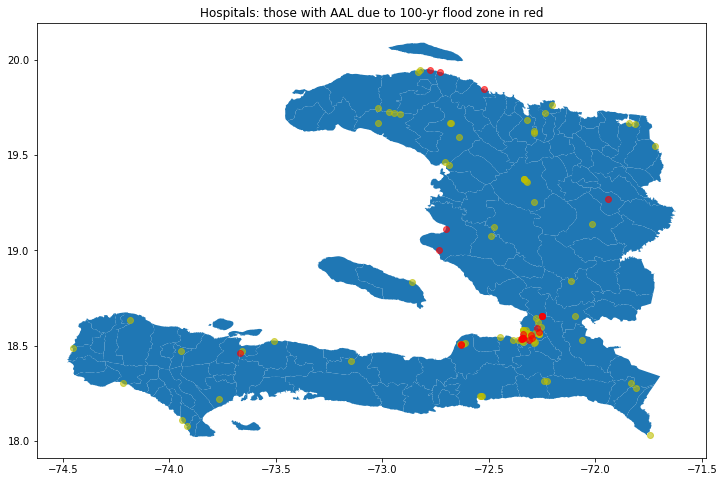

In [305]:
fig, ax = plt.subplots(1, figsize=(12,8))
base = ADM.plot(ax=ax)
no_flood = hospitals[hospitals['AAL_100yr']==0].plot(c='y',ax=ax,alpha=0.6)
flood = hospitals[hospitals['AAL_100yr']>0].plot(alpha=0.6,color='r',ax=ax)
ax.set_title('Hospitals: those with AAL due to 100-yr flood zone in red')
print("Number of hospitals with losses due to being in 100-yr flood zone: {}".format(hospitals[hospitals['AAL_100yr']>0].shape[0]))